# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col,udf




import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

import pyspark
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import GBTClassifier, LinearSVC, RandomForestClassifier

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import when, count, avg, explode, concat, lit, min, max, split, udf, isnull, col, desc,isnan, udf, isnull,sum
from pyspark.sql import Window

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify-project").getOrCreate()

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# read the dataset into the dataframe
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [7]:
# find the shape of the dataframe 
print("Number of rows {}".format(df.count()))
print("Number of columns{}".format(len(df.columns)))

Number of rows 286500
Number of columns18


In [8]:
# understand the schema of the dataset
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# check for na values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [10]:
# in order to build a model for churn prediction , the user id and session id should not be nulls, if so drop such rows
df= df.dropna(how='any', subset=['userId','sessionId'])

In [11]:
# find the shape of the dataframe 
print("Number of rows {}".format(df.count()))
print("Number of columns{}".format(len(df.columns)))

Number of rows 286500
Number of columns18


In [12]:
# remove rows where user id string is empty
df = df.filter(df['userId'] != "")
df.show()
df.collect()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [13]:
df.count()

278154

In [14]:
# find the shape of the dataframe 
print("Number of rows {}".format(df.count()))
print("Number of columns{}".format(len(df.columns)))

Number of rows 278154
Number of columns18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Assess the dataset 

In [15]:
# convert the time stamp columns into appropriate data types
ts_udf = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
#adding new columns with updated values
df = df.withColumn('converted_registration', ts_udf('registration'))
df = df.withColumn('converted_ts', ts_udf('ts'))

In [16]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+----------------------+-------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|converted_registration|       converted_ts|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+----------------------+-------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   09-28-2018 22:22:42|10-01-2018 00:01:57|
+--------------+---------+---------+

In [17]:
# find all unique pages
df.select("page").dropDuplicates().show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [18]:
# create a downgrade label  column with page value of 1 or 0
downgrade_label  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_label", downgrade_label("page"))

# create column of users who downgraded 
df_window_user = Window.partitionBy('UserId')
df = df.withColumn("user_downgraded", max('downgrade_label').over(df_window_user))

# create a churn label column
churn_label = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_label", churn_label("page"))

# create column for users who churned
df_churn_window = Window.partitionBy('UserId')
df = df.withColumn("user_churned", max('churn_label').over(df_churn_window))

# show the transformed dataset
df.select(['userId', 'firstName','lastName', 'level','converted_registration','converted_ts','user_churned', 'user_downgraded']).dropDuplicates(subset = ['userId']).show(10) 

+------+---------+---------+-----+----------------------+-------------------+------------+---------------+
|userId|firstName| lastName|level|converted_registration|       converted_ts|user_churned|user_downgraded|
+------+---------+---------+-----+----------------------+-------------------+------------+---------------+
|100010| Darianna|Carpenter| free|   09-27-2018 02:45:40|10-08-2018 12:58:54|           0|              0|
|200002|  Dominic|   Torres| free|   09-06-2018 21:38:26|10-01-2018 11:30:30|           0|              0|
|   125|    Mason|     Hart| free|   08-01-2018 20:58:59|10-12-2018 04:05:44|           1|              0|
|   124|   Nicole|     Beck| paid|   07-22-2018 01:52:15|10-01-2018 15:17:10|           0|              0|
|    51|    Ethan|  Johnson| paid|   09-27-2018 20:43:07|10-01-2018 12:57:12|           1|              0|
|     7|   Maddox|  Johnson| free|   09-11-2018 12:06:16|10-03-2018 11:57:49|           0|              0|
|    15|    Panav|    Myers| paid|   

In [19]:
# analyze the data distribution for churned users based on geneder of users
df.drop_duplicates(['userId', 'gender']).groupby(['user_churned', 'gender']).count().sort("user_churned").show()

+------------+------+-----+
|user_churned|gender|count|
+------------+------+-----+
|           0|     M|   89|
|           0|     F|   84|
|           1|     F|   20|
|           1|     M|   32|
+------------+------+-----+



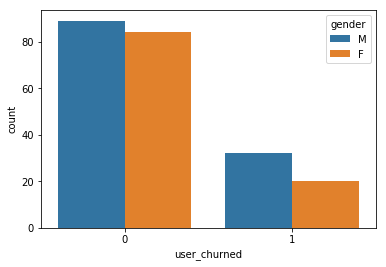

In [20]:
# plot the distribution
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churned', 'gender']).count().sort("user_churned").toPandas()
sns.barplot(x = 'user_churned', y = 'count', data = df_ch_pd, hue = 'gender')

### Observation
Male users are more likely to churn than female users.

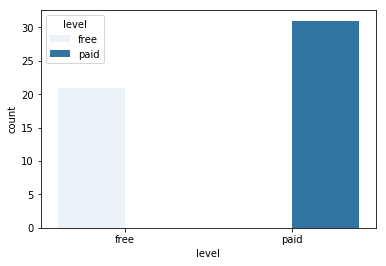

In [21]:
# check if the free or paid users churned more or less
level_df = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[0], hue='level');

### Observation
Paid users are more likely to churn than free users

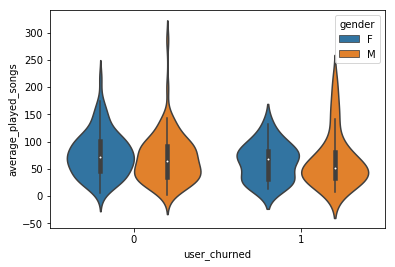

In [22]:
# gender distribution for number of songs played per session for churned and normal users
total_songs_df = df.where('page == "NextSong"').groupby(['user_churned', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churned', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'average_played_songs').toPandas()

ax = sns.violinplot('user_churned', y = 'average_played_songs', hue = 'gender', data = total_songs_df)

### Observation
Churned users tend to play less number of songs on an average than non-churned users.

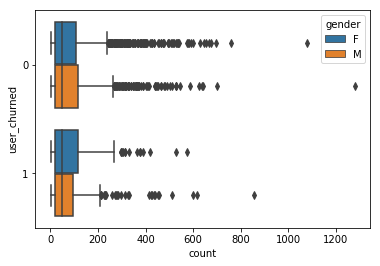

In [23]:
# gender distribution for total user engagements per session between normal and churned users
df_engage = df.groupby("user_churned", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'user_churned', orient = 'horizontal', data = df_engage ,hue = 'gender')

### Observation
Churned users tend to be having less engagement with the website than non-churned users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
# since we are working in the classroom setup we will be selecting only single features
# count of songs per user
feature1 = df.select(['userId','song']).groupBy(['userId']).count().withColumnRenamed('count','number_songs_per_user') 

In [25]:
feature1.show(2)

+------+---------------------+
|userId|number_songs_per_user|
+------+---------------------+
|100010|                  381|
|200002|                  474|
+------+---------------------+
only showing top 2 rows



In [26]:
# count of thumbs up a user gives
feature2 = df.select(['userId','page']).where(df['page'] == 'Thumbs Up').groupBy(['userId']) \
             .count().withColumnRenamed('count','number_thumbs_up_per_user')

In [27]:
feature2.show()

+------+-------------------------+
|userId|number_thumbs_up_per_user|
+------+-------------------------+
|100010|                       17|
|200002|                       21|
|    51|                      100|
|   124|                      171|
|     7|                        7|
|    54|                      163|
|    15|                       81|
|   155|                       58|
|   132|                       96|
|   154|                       11|
|100014|                       17|
|   101|                       86|
|    11|                       40|
|   138|                       95|
|300017|                      303|
|    29|                      154|
|    69|                       72|
|100021|                       11|
|    42|                      166|
|   112|                        9|
+------+-------------------------+
only showing top 20 rows



In [28]:
# count of thumbs dowb a user gives
feature3 = df.select(['userId','page']).where(df['page'] == 'Thumbs Down').groupBy(['userId']) \
             .count().withColumnRenamed('count','number_thumbs_down_per_user')

In [29]:
feature3.show()

+------+---------------------------+
|userId|number_thumbs_down_per_user|
+------+---------------------------+
|100010|                          5|
|200002|                          6|
|    51|                         21|
|   124|                         41|
|     7|                          1|
|    15|                         14|
|    54|                         29|
|   155|                          3|
|   132|                         17|
|100014|                          3|
|   101|                         16|
|    11|                          9|
|   138|                         24|
|300017|                         28|
|    29|                         22|
|    69|                          9|
|100021|                          5|
|    42|                         25|
|   112|                          3|
|    73|                          7|
+------+---------------------------+
only showing top 20 rows



In [30]:
# total time since the user registered in days
feature4 = df.select('userId', 'registration', 'ts').withColumn('total_time', (df.ts - df.registration))\
            .groupBy('userId').agg({'total_time' : 'max'})\
            .withColumnRenamed('max(total_time)', 'total_time')\
            .select('userId', (col('total_time')/1000/3600/24).alias('total_time'))


In [31]:
feature4.show()

+------+------------------+
|userId|        total_time|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [32]:
# total hours of music listened
feature5 = df.select(['userId','length']).groupBy(['userId']).sum()\
             .withColumnRenamed('sum(length)','total_songtime_per_user') 

In [33]:
feature5.show()

+------+-----------------------+
|userId|total_songtime_per_user|
+------+-----------------------+
|100010|      66940.89735000003|
|200002|      94008.87593999993|
|   125|     2089.1131000000005|
|    51|      523275.8428000004|
|   124|     1012312.0927899999|
|     7|      38034.08710000002|
|    54|      711344.9195400011|
|    15|     477307.60581000015|
|   155|            198779.2919|
|   132|      483118.9038399997|
|   154|     20660.023910000007|
|100014|      67703.47208000004|
|   101|      447464.0146699989|
|    11|     159669.96303999983|
|   138|      512449.8827599989|
|300017|      897406.9802100015|
|    29|      754517.5625700009|
|    69|      286064.0256399999|
|100021|      57633.17563999999|
|    42|      881792.9661300007|
+------+-----------------------+
only showing top 20 rows



In [34]:
# converting the gender of the user from catgorical variable to numerical variable using one-hot encoding
feature6 = df.select(['userId','gender']).dropDuplicates().replace(['F','M'],['0','1'], 'gender')\
             .select(['userId', col('gender').cast('int')])


In [35]:
feature6.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



In [36]:
# total number of songs played per session
feature7 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'average_played_songs') 

In [37]:
feature7.show()

+------+--------------------+
|userId|average_played_songs|
+------+--------------------+
|100010|  39.285714285714285|
|200002|                64.5|
|   125|                 8.0|
|    51|               211.1|
|   124|  145.67857142857142|
|     7|  21.428571428571427|
|    54|   81.17142857142858|
|    15|  136.71428571428572|
|   155|  136.66666666666666|
|100014|  42.833333333333336|
|   132|               120.5|
|   154|                28.0|
|   101|               179.7|
|    11|             40.4375|
|300017|  59.540983606557376|
|   138|               138.0|
|    29|   89.05882352941177|
|    69|               125.0|
|100021|                46.0|
|    42|   87.14634146341463|
+------+--------------------+
only showing top 20 rows



In [38]:
# setting the churned column as target
target = df.select('userId', col('user_churned').alias('target')).dropDuplicates()
target.show()

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     0|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     0|
+------+------+
only showing top 20 rows



In [39]:
# Combining all features with the target churn label

final_df = feature1.join(feature2, 'userId', 'inner').join(feature3, 'userId', 'inner').join(feature4, 'userId', 'inner')\
             .join(feature5, 'userId', 'inner').join(feature6, 'userId', 'inner').join(feature7, 'userId', 'inner')\
             .join(target, 'userId', 'inner').drop('userId')

final_df.show()

+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+
|number_songs_per_user|number_thumbs_up_per_user|number_thumbs_down_per_user|        total_time|total_songtime_per_user|gender|average_played_songs|target|
+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+
|                  381|                       17|                          5|  55.6436574074074|      66940.89735000003|     0|  39.285714285714285|     0|
|                  474|                       21|                          6| 70.07462962962963|      94008.87593999993|     1|                64.5|     0|
|                 2464|                      100|                         21|19.455844907407407|      523275.8428000004|     1|               211.1|     1|
|                 4825|                      171|               

In [40]:
final_df.printSchema()

root
 |-- number_songs_per_user: long (nullable = false)
 |-- number_thumbs_up_per_user: long (nullable = false)
 |-- number_thumbs_down_per_user: long (nullable = false)
 |-- total_time: double (nullable = true)
 |-- total_songtime_per_user: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- average_played_songs: double (nullable = true)
 |-- target: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
# Step 1 :  vectorize all of our features

inputColumns = ['number_songs_per_user', 'number_thumbs_up_per_user', 'number_thumbs_up_per_user', 'total_time', 'total_songtime_per_user', 'gender', 'average_played_songs']
assmblr = VectorAssembler(inputCols = inputColumns, outputCol = "VectorizedFeatures")
final_df = assmblr.transform(final_df)
final_df.show()

+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+--------------------+
|number_songs_per_user|number_thumbs_up_per_user|number_thumbs_down_per_user|        total_time|total_songtime_per_user|gender|average_played_songs|target|  VectorizedFeatures|
+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+--------------------+
|                  381|                       17|                          5|  55.6436574074074|      66940.89735000003|     0|  39.285714285714285|     0|[381.0,17.0,17.0,...|
|                  474|                       21|                          6| 70.07462962962963|      94008.87593999993|     1|                64.5|     0|[474.0,21.0,21.0,...|
|                 2464|                      100|                         21|19.455844907407407|      523275.842800

In [42]:
# Step 2 : Standardizing all input features 
scaler = StandardScaler(inputCol = 'VectorizedFeatures', outputCol = "features", withStd = True)
scaler_model = scaler.fit(final_df)
final_df = scaler_model.transform(final_df)

In [43]:
final_df.show()

+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+--------------------+--------------------+
|number_songs_per_user|number_thumbs_up_per_user|number_thumbs_down_per_user|        total_time|total_songtime_per_user|gender|average_played_songs|target|  VectorizedFeatures|            features|
+---------------------+-------------------------+---------------------------+------------------+-----------------------+------+--------------------+------+--------------------+--------------------+
|                  381|                       17|                          5|  55.6436574074074|      66940.89735000003|     0|  39.285714285714285|     0|[381.0,17.0,17.0,...|[0.28392000516840...|
|                  474|                       21|                          6| 70.07462962962963|      94008.87593999993|     1|                64.5|     0|[474.0,21.0,21.0,...|[0.35322331351659...|
|         

In [44]:
# selecting the final dataframe of vectorized feature column and label column
processed_data = final_df.select(final_df.target.alias("label"), final_df.features)

In [45]:
processed_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28392000516840...|
|    0|[0.35322331351659...|
+-----+--------------------+
only showing top 2 rows



In [46]:
training_data, val_data = processed_data.randomSplit([0.85, 0.15], seed = 42)
training_data = training_data.cache()

In [47]:
# selecting random forest classifier for the first model to apply to this dataset

rf = RandomForestClassifier()
f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cval_rf = CrossValidator(estimator = rf, estimatorParamMaps = param_grid, evaluator = f1_eval, numFolds = 2)

In [48]:
# built the cross-validation model for random forest
model_rf = cval_rf.fit(training_data)
model_rf.avgMetrics

[0.7970814908933721]

In [49]:
# test the f1 score on the validation set
result_rf = model_rf.transform(val_data)

In [50]:
# get the stats for the random forest
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Random Forest Classifier metrics are as below :")
print("The F-1 Score is {}".format(evaluator.evaluate(result_rf, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(result_rf, {evaluator.metricName : "f1"})))

Random Forest Classifier metrics are as below :
The F-1 Score is 0.8260869565217391
The accuracy is 0.8009661835748794


In [51]:
# Building SVM machine learning model now
svm = LinearSVC(maxIter = 15)
f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cval_svm = CrossValidator(estimator = svm, estimatorParamMaps = param_grid, evaluator = f1_eval, numFolds = 2)

In [52]:
# built the cross-validation model for svm
model_svm = cval_svm.fit(training_data)
model_svm.avgMetrics

[0.6839805135053159]

In [53]:
# test the f1 score on the validation set
result_svm = model_svm.transform(val_data)

In [54]:
# get the stats for the SVM
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("SVM Classifier metrics are as below :")
print("F-1 Score is {}".format(evaluator.evaluate(result_svm, {evaluator.metricName : "accuracy"})))
print("Accuracy is {}".format(evaluator.evaluate(result_svm, {evaluator.metricName : "f1"})))

SVM Classifier metrics are as below :
F-1 Score is 0.6956521739130435
Accuracy is 0.5707915273132664


In [55]:
# Using GBT classifier now
gbt = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)
f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cval_gbt = CrossValidator(estimator = gbt, estimatorParamMaps = param_grid, evaluator = f1_eval, numFolds = 2)

In [56]:
# built the cross-validation model for svm
model_gbt = cval_gbt.fit(training_data)
model_gbt.avgMetrics

[0.7494125589953031]

In [57]:
# test the f1 score on the validation set
result_gbt = model_gbt.transform(val_data)

In [58]:
# get the stats for the gradient boosting
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("GBT Classifier metrics are as below :")
print("F-1 Score is {}".format(evaluator.evaluate(result_gbt, {evaluator.metricName : "accuracy"})))
print("Accuracy is {}".format(evaluator.evaluate(result_gbt, {evaluator.metricName : "f1"})))

GBT Classifier metrics are as below :
F-1 Score is 0.782608695652174
Accuracy is 0.7775412992804297


### Model comparison and Analysis
Based on the F1 score of the three models it seems that the Random Forest classifier performs the best and so we would now do some model hyper parameter tuning for this model to try and improve the accuracy and the F1 score.

In [59]:
rf = RandomForestClassifier(maxDepth=10)
f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cval_rf = CrossValidator(estimator = rf, estimatorParamMaps = param_grid, evaluator = f1_eval, numFolds = 2)

In [60]:
# built the cross-validation model for random forest
model_rf = cval_rf.fit(training_data)
model_rf.avgMetrics

[0.8041890604089539]

In [61]:
# test the f1 score on the validation set
result_rf = model_rf.transform(val_data)

In [62]:
# get the stats for the random forest
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("Random Forest Classifier metrics after hyperparamter tuning are as  below :")
print("The F-1 Score is {}".format(evaluator.evaluate(result_rf, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(result_rf, {evaluator.metricName : "f1"})))

Random Forest Classifier metrics after hyperparamter tuning are as  below :
The F-1 Score is 0.8260869565217391
The accuracy is 0.8009661835748794


## Conclusion


We applied data processing to the small dataset and then extracted features which we thought would help predict the churn of the users. For this we used 3 Machine learning algorithms of Random Forest, SVM and Gradient Bossted trees and saw that Random forest did a better job at predicting the model. An attempt to further perform hyper parameter tuning to enhance the performance of the classifier did not provide any further gains in the classifier performance in making the prediction.

It may be worth while to try and add more features or choose any other classifier to even try and improve the accuracy of the prediction via those trials.

### Reflection & Remarks
This project gives me exposure to Apache Spark which is typically used for big data applications and large-scale machine learning pipeline. 
I worked with PySpark and Pandas and used a few other packages to build the end-to-end pipeline for building a model for predicting customer churn. The challenges working on this project was to identify features that closely represented how likely a customer will churn or not out of all the available attributes. Using Spark MlLib gave me exposure to the various machine learning classifiers as part of the Spark framework. 
Having more domain experience and a better understanding of the data perhaps I could build a more performant model in the future which is even better at making the churn prediction.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.